In [ ]:
import yfinance as yf
import pandas as pd

tickers = ["AAPL", "TSLA", "JPM", "XOM", "NVDA"]
data = yf.download(tickers, start="2010-01-01", end="2025-01-01", auto_adjust=False)["Close"]
returns = data.pct_change().dropna()
print(returns.head())


[*********************100%***********************]  5 of 5 completed

Ticker          AAPL       JPM      NVDA      TSLA       XOM
Date                                                        
2010-06-30 -0.018113 -0.012142 -0.025763 -0.002511 -0.003840
2010-07-01 -0.012126 -0.014477  0.016650 -0.078473 -0.008060
2010-07-02 -0.006198 -0.006929 -0.012524 -0.125683 -0.000707
2010-07-06  0.006844  0.013955 -0.010732 -0.160937  0.015733
2010-07-07  0.040381  0.050096  0.048323 -0.019243  0.016881


Feature Engineering (Adding Key Market Indicators)

To detect anomalies, we need features that capture price movements and market behavior.

Rolling Volatility (30-day std dev) → Detects periods of high market stress.
Bollinger Bands → Helps identify extreme price movements.
Relative Strength Index (RSI) → Detects overbought/oversold conditions.
Moving Average Convergence Divergence (MACD) → Measures trend momentum.
Z-score of Returns → Identifies extreme return deviations.



In [ ]:
def compute_features(df):
    features = pd.DataFrame(index=df.index)

    # Rolling Volatility (30-day)
    volatility = df.rolling(window=30).std()
    volatility.columns = [f"{col}_Volatility" for col in df.columns]

    # Bollinger Bands
    rolling_mean = df.rolling(window=20).mean()
    rolling_std = df.rolling(window=20).std()
    bollinger_upper = rolling_mean + (rolling_std * 2)
    bollinger_lower = rolling_mean - (rolling_std * 2)

    # RSI
    delta = df.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # MACD
    ema_12 = df.ewm(span=12, adjust=False).mean()
    ema_26 = df.ewm(span=26, adjust=False).mean()

    # Z-score
    z_score = (df - df.mean()) / df.std()

    # Combine all features
    features = pd.concat([volatility], axis=1)

features = compute_features(returns)

print(features.head())


            AAPL_Volatility  JPM_Volatility  NVDA_Volatility  TSLA_Volatility  \
Date                                                                            
2010-08-11         0.015135        0.020046         0.032897         0.058080   
2010-08-12         0.014820        0.019896         0.032752         0.058093   
2010-08-13         0.014781        0.019757         0.033906         0.057208   
2010-08-16         0.014776        0.019702         0.034119         0.052624   
2010-08-17         0.015066        0.019612         0.034215         0.042944   

            XOM_Volatility  AAPL_Bollinger_Upper  JPM_Bollinger_Upper  \
Date                                                                    
2010-08-11        0.012829              0.028147             0.034909   
2010-08-12        0.012812              0.028786             0.034779   
2010-08-13        0.012749              0.028841             0.033008   
2010-08-16        0.012747              0.028413             0.0333

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

X = features.values

# Train Isolation Forest (detects rare anomalies)
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_labels = iso_forest.fit_predict(X)

# Train One-Class SVM (learns a boundary for normal behavior)
svm_model = OneClassSVM(nu=0.01, kernel="rbf")
svm_labels = svm_model.fit_predict(X)

features["IsolationForest_Anomaly"] = iso_labels
features["OneClassSVM_Anomaly"] = svm_labels

print(features[["IsolationForest_Anomaly", "OneClassSVM_Anomaly"]].head(20))


            IsolationForest_Anomaly  OneClassSVM_Anomaly
Date                                                    
2010-08-11                        1                   -1
2010-08-12                        1                    1
2010-08-13                        1                    1
2010-08-16                        1                    1
2010-08-17                        1                    1
2010-08-18                        1                    1
2010-08-19                        1                    1
2010-08-20                        1                    1
2010-08-23                        1                    1
2010-08-24                        1                    1
2010-08-25                        1                    1
2010-08-26                        1                    1
2010-08-27                        1                    1
2010-08-30                        1                    1
2010-08-31                        1                    1
2010-09-01                     

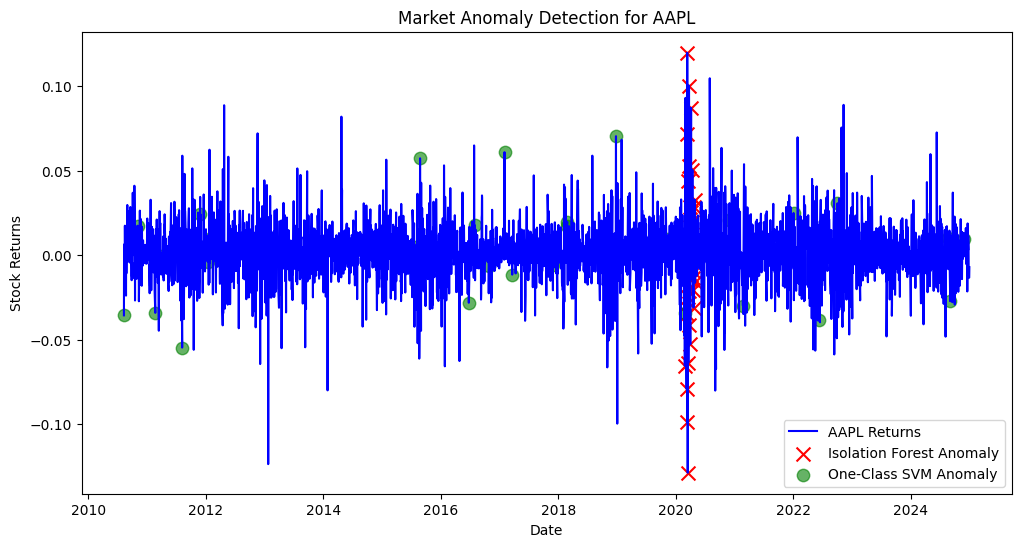

In [ ]:
import matplotlib.pyplot as plt

stock = "AAPL"

common_dates = returns.index.intersection(features.index)
aligned_returns = returns.loc[common_dates, stock]
aligned_anomalies = features.loc[common_dates]

anomaly_iso = aligned_anomalies["IsolationForest_Anomaly"]
anomaly_svm = aligned_anomalies["OneClassSVM_Anomaly"]

# Plot Isolation Forest anomalies
plt.scatter(aligned_returns.index[anomaly_iso == -1],
            aligned_returns[anomaly_iso == -1],
            color="red", label="Isolation Forest Anomaly", marker="x", s=100)

# Plot One-Class SVM anomalies
plt.scatter(aligned_returns.index[anomaly_svm == -1],
            aligned_returns[anomaly_svm == -1],
            color="green", label="One-Class SVM Anomaly", marker="o", s=80, alpha=0.6)

plt.legend()
plt.title(f"Market Anomaly Detection for {stock}")
plt.xlabel("Date")
plt.ylabel("Stock Returns")
plt.show()


**Key Observations**

Red "X" markers (Isolation Forest anomalies)

A significant cluster of anomalies occurs around 2020, likely due to the COVID-19 market crash.
This suggests Isolation Forest detects large drawdowns as anomalies.
Green circles (One-Class SVM anomalies)

These are more evenly spread throughout the timeline.
One-Class SVM seems to capture anomalies in both large positive & negative spikes in returns.
General Market Volatility

The return distribution remains relatively stable, except for sharp spikes (which are detected as anomalies).
